# Semantic Kernel Multi Agent Collaboration

## Load Azure Configurations

In [1]:
from dotenv import load_dotenv
import os

azure_openai_endpoint = os.getenv("AZURE_OPENAI_ENDPOINT")
azure_openai_key = os.getenv("AZURE_OPENAI_API_KEY")
azure_openai_deployment = os.getenv("AZURE_OPENAI_CHAT_DEPLOYMENT_NAME")
azure_openai_api_version = os.getenv("AZURE_OPENAI_API_VERSION")

## Create the Azure OpenAI Clients to be used by Plugins


In [2]:
from openai import AzureOpenAI

# Create the Dalle client
dalle_client = AzureOpenAI(
    api_key=azure_openai_key, 
    api_version=azure_openai_api_version,
    azure_endpoint=azure_openai_endpoint
)
dalle_deployment_name = "dall-e-3"

# Create the Vision client
vision_client = AzureOpenAI(
    api_key=azure_openai_key, 
    api_version=azure_openai_api_version,
    azure_endpoint=azure_openai_endpoint
)
vision_deployment_name = "gpt-4"

## Define Plugins

In [3]:
from typing import Annotated
from semantic_kernel.functions.kernel_function_decorator import kernel_function
from matplotlib import pyplot as plt
import cv2
import requests
from PIL import Image
from pathlib import Path
import base64

class GenerateImagePlugin:
    """Generates an Image Plugin"""

    @kernel_function(description="Generates or creates an image")
    def generate_image(self, 
        prompt: Annotated[str, "Prompt to generate an image coming from user and Vision Assistant"]) -> Annotated[str, "Displays a response that an image was generated"]:
        """
        Call the Azure OpenAI Dall-e 3 model to generate an image from a text prompt.
        Executes the call to the Azure OpenAI Dall-e 3 image creator, saves the file into the local directory, and displays the image.
        """

        print("\n" + "Dalle Assistant Message: Creating the image ...")

        response = dalle_client.images.generate(
            model=dalle_deployment_name, prompt=prompt, size="1024x1024", quality="standard", n=1
        )

        # Retrieve the image URL from the response (assuming response structure)
        image_url = response.data[0].url

        # Open the image from the URL and save it to a temporary file.
        im = Image.open(requests.get(image_url, stream=True).raw)

        # Define the filename and path where the image should be saved.
        filename = "temp.jpg"
        local_path = Path(filename)

        # Save the image.
        im.save(local_path)

        # Get the absolute path of the saved image.
        full_path = str(local_path.absolute())

        img = cv2.imread("temp.jpg", cv2.IMREAD_UNCHANGED)

        # Convert the image from BGR to RGB for displaying with matplotlib,
        # because OpenCV uses BGR by default and matplotlib expects RGB.
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        # Display the image with matplotlib.
        plt.imshow(img_rgb)
        plt.axis("off")  # Turn off axis labels.
        plt.show()

        # Return the full path of the saved image.
        print("Dalle Assistant Message: " + full_path)
        return "Image generated successfully and store in the local file system. You can now use this image to analyze it with the vision_assistant"
    
class AnalyzeImagePlugin:
    """Analyzes an Image Plugin"""

    @kernel_function(description="Analyzes and enhances an image")
    def analyze_image(self) -> Annotated[str, "Returns new prompt that enhances the image based on the criticism and analysis."]:
        """
        Call the Azure OpenAI GPT4 Vision model to analyze and critic an image and return the result.
        The resulting output should be a new prompt for dall-e that enhances the image based on the criticism and analysis
        """
        print("\n" + "Vision Assistant Message: " + "Analyzing the image...")

        # Create a Path object for the image file
        image_path = Path("temp.jpg")

        # Using a context manager to open the file with Path.open()
        with image_path.open("rb") as image_file:
            base64_image = base64.b64encode(image_file.read()).decode("utf-8")

        content_images = [
            {"type": "image_url", "image_url": {"url": f"data:image/jpeg;base64,{base64_image}"}}
            for base64_image in [base64_image]
        ]
        response = vision_client.chat.completions.create(
            model=vision_deployment_name,
            messages=[
                {
                    "role": "user",
                    "content": [
                        {
                            "type": "text",
                            "text": "Analyze and critic this image and generate a new enhanced prompt for Dall-e with the criticism and analysis.",
                        },
                        *content_images,
                    ],
                }
            ],
            max_tokens=1000,
        )
        print("Vision Assistant Message: " + response.choices[0].message.content)
        return response.choices[0].message.content

## Helper Function to create a Kernel

In [4]:
from semantic_kernel.connectors.ai.open_ai.services.azure_chat_completion import AzureChatCompletion
from semantic_kernel.kernel import Kernel

def _create_kernel_with_chat_completion(service_id: str) -> Kernel:
    kernel = Kernel()
    kernel.add_service(AzureChatCompletion(service_id=service_id))
    return kernel

## Create the Agents

In [5]:
from semantic_kernel.connectors.ai.function_choice_behavior import FunctionChoiceBehavior
from semantic_kernel.contents.chat_message_content import ChatMessageContent
from semantic_kernel.contents.utils.author_role import AuthorRole
from semantic_kernel.functions.kernel_function_from_prompt import KernelFunctionFromPrompt
from semantic_kernel.agents.strategies.selection.kernel_function_selection_strategy import KernelFunctionSelectionStrategy
from semantic_kernel.agents.strategies.termination.kernel_function_termination_strategy import KernelFunctionTerminationStrategy
from semantic_kernel.agents import AgentGroupChat,  ChatCompletionAgent
from semantic_kernel.agents.open_ai.azure_assistant_agent import AzureAssistantAgent

DALLE_NAME = "DalleAssistant"
VISION_NAME = "VisionAssistant"
MANAGER_NAME = "Manager"
TERMINATION_KEYWORD = "yes"

### Manager Assistant
# Create the instance of the Kernel
manager_kernel = _create_kernel_with_chat_completion(MANAGER_NAME)

# Create the agent
manager_agent = ChatCompletionAgent(
    service_id=MANAGER_NAME, 
    kernel=manager_kernel, 
    name=MANAGER_NAME, 
    instructions=f"""
        You count the number of conversations between {DALLE_NAME} and {VISION_NAME}.
        An image generated by {DALLE_NAME} and an analysis by {VISION_NAME} is considered as a single conversation.
        Once four (4) conversations are completed, you will provide a termination message: {TERMINATION_KEYWORD}
        """
)

### DALLE Assistant
# Create the instance of the Kernel
dalle_assistant_kernel = _create_kernel_with_chat_completion(DALLE_NAME)
dalle_assistant_kernel.add_plugin(GenerateImagePlugin(), plugin_name="GenerateImagePlugin")

settings = dalle_assistant_kernel.get_prompt_execution_settings_from_service_id(service_id=DALLE_NAME)
# Configure the function choice behavior to auto invoke kernel functions
settings.function_choice_behavior = FunctionChoiceBehavior.Required()

# Create the agent
dalle_assistant_agent = ChatCompletionAgent(
    service_id=DALLE_NAME, 
    kernel=dalle_assistant_kernel, 
    name=DALLE_NAME, 
    instructions="""
        As a premier AI specializing in image generation, you possess the expertise to craft precise visuals based on given prompts. 
        It is essential that you diligently generate the requested image, ensuring its accuracy and alignment with the user's specifications, 
        prior to delivering a response.
        You will have access to the local file system to store the generated image.
        You will generate an image based on the user's prompt and display it for review.
        You will generate new images based on the feedback from the Vision Assistant.
        """, 
    execution_settings=settings
)

### Vision Assistant
# Create the instance of the Kernel
vision_assistant_kernel = _create_kernel_with_chat_completion(VISION_NAME)
vision_assistant_kernel.add_plugin(AnalyzeImagePlugin(), plugin_name="AnalyzeImagePlugin")

settings = vision_assistant_kernel.get_prompt_execution_settings_from_service_id(service_id=VISION_NAME)
# Configure the function choice behavior to auto invoke kernel functions
settings.function_choice_behavior = FunctionChoiceBehavior.Required()

# Create the agent
vision_assistant_agent = ChatCompletionAgent(
    service_id=VISION_NAME, 
    kernel=vision_assistant_kernel, 
    name=VISION_NAME, 
    instructions=""" 
        As a leading AI expert in image analysis, you excel at scrutinizing and offering critiques to refine and improve images. 
        Your task is to thoroughly analyze an image, ensuring that all essential assessments are completed with precision 
        before you provide feedback to the user. You have access to the local file system where the image is stored.
        You will analyze the image and provide a new prompt for Dall-e that enhances the image based on the criticism and analysis.
        You will then instruct the Dall-e Assistant to generate a new image based on the new prompt.
        """, 
    execution_settings=settings
)


## Create the Selection Function, Termination Function, and Agent Group Chat

In [6]:
selection_function = KernelFunctionFromPrompt(
    function_name="selection",
    prompt=f"""
        Determine which participant takes the next turn in a conversation based on the most recent participant.
        State only the name of the participant to take the next turn.
        Choose only from these participants:
        - {DALLE_NAME}
        - {VISION_NAME}
        - {MANAGER_NAME}
        
        You will follow this sequence:
        {DALLE_NAME} will generate an image based on the initial user prompt and display it for review.
        {VISION_NAME} will analyze the image and provide a new prompt for {DALLE_NAME} to generate a new image based on the new prompt.
        {DALLE_NAME} will generate an image based on the {VISION_NAME} prompt and display it for review.
        {VISION_NAME} will analyze the image and provide a new prompt for {DALLE_NAME} to generate a new image based on the new prompt.
        {DALLE_NAME} will generate an image based on the {VISION_NAME} prompt and display it for review.
        {VISION_NAME} will analyze the image and provide a new prompt for {DALLE_NAME} to generate a new image based on the new prompt.
        
        {MANAGER_NAME} will count the number of conversations between {DALLE_NAME} and {VISION_NAME}.
        
        No participant should take more than one turn in a row.

        History:
        {{{{$history}}}}
        """,
)

termination_function = KernelFunctionFromPrompt(
    function_name="termination",
    prompt=f"""
        Determine if the conversation should be terminated based on the number of conversations by the {MANAGER_NAME}.
        If number of conversations is reached, respond with the termination keyword: {TERMINATION_KEYWORD}
        RESPONSE:
        {{{{$history}}}}"""
)

chat = AgentGroupChat(
    agents=[dalle_assistant_agent, vision_assistant_agent, manager_agent],
    selection_strategy=KernelFunctionSelectionStrategy(
        function=selection_function,
        kernel=_create_kernel_with_chat_completion("selection"),
        result_parser=lambda result: str(result.value[0]) if result.value is not None else DALLE_NAME or VISION_NAME,
        agent_variable_name="agents",
        history_variable_name="history"
    ),
    termination_strategy=KernelFunctionTerminationStrategy(
        agents=[manager_agent],
        function=termination_function,
        kernel=_create_kernel_with_chat_completion("termination"),
        result_parser=lambda result: TERMINATION_KEYWORD in str(result.value[0]).lower(),
        history_variable_name="history",
        maximum_iterations=10,
    ),
)


Dalle Assistant Message: Creating the image ...


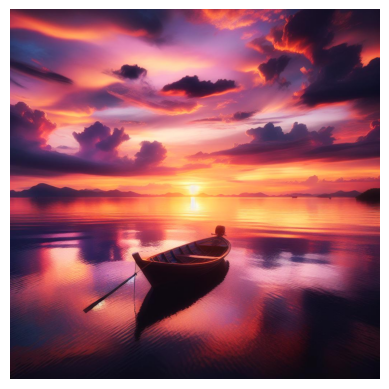

Dalle Assistant Message: /workspaces/AzureAI/SemanticKernelAgents/temp.jpg
# AuthorRole.ASSISTANT - DalleAssistant: 'Here is the image of a boat drifting in the water with a sunset in the background. Please review it and let me know if there are any adjustments you would like.'

Vision Assistant Message: Analyzing the image...
Vision Assistant Message: **Analysis and Criticism:**

This image features a picturesque scene with a boat at sunset on serene waters. The colors are exceptionally vibrant, with a dominant palette of purples, oranges, and reds, which brings energy and warmth to the scene. The sky is dramatized with varied cloud formations, and the sun sits just above the horizon, casting a radiant glow. The reflection on the water surface adds to the tranquility and the overall aesthetics of the composition.

While the image is beautifully crafted, there are a few areas where it might be enhanced further:
1. **Contrast and Detailing:** The boat and the lone figure within it are s

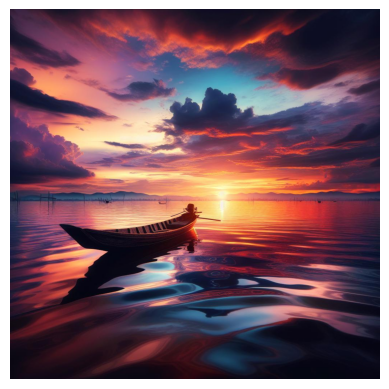

Dalle Assistant Message: /workspaces/AzureAI/SemanticKernelAgents/temp.jpg
# AuthorRole.ASSISTANT - DalleAssistant: 'I have generated a new image based on the enhanced prompt. Please review it and let me know if it aligns with your expectations or requires further adjustments.'

Vision Assistant Message: Analyzing the image...
Vision Assistant Message: ### Analysis and Critique
**Subject & Composition:**
The image depicts a tranquil scene with a lone figure in a boat on a body of water, witnessing a stunning sunset. The use of vibrant colors in the sky contrasts with the darker tones of the water, creating a visually appealing balance. The composition is well-executed with the boat positioned toward the bottom left, which guides the eye through the image and towards the radiant sunset on the horizon.

**Color Palette:**
The artist has chosen a vivid color palette, dominated by shades of red, orange, purple, and blue, which imbue the scene with a sense of warmth and depth. Although beau

In [7]:
user_input = "Generate an image of a boat drifting in the water, with a sunset in the background"
await chat.add_chat_message(ChatMessageContent(role=AuthorRole.USER, content=user_input))
try:
    async for response in chat.invoke():
        print(f"# {response.role} - {response.name or '*'}: '{response.content}'")
except Exception as e:
    print(e)

# Evaluate if completion is met and reset
if chat.is_complete:
    # Reset completion state to continue reuse of chat.
    chat.is_complete = False

#reset the chat
await chat.reset()